### EIGENSTRAT

In [1]:
import numpy as np
import pandas as pd
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=2)
sns.set_style("white")
%matplotlib inline
pop_colors = ['purply pink', 'golden', 'leaf green', 'blood', 'vomit', 'primary blue', 
              'bright sky blue', 'dark cyan', 'grey', 'red']

#### Dominance coding
Haplotypes is a class to store the haplotypes assigned to a group of indidividuals at a particular catalog ID.
- 1 = allele is present
- 0 = allele is absent
- 9 = no call

In [2]:
import collections

class Haplotypes(object):
    def __init__(self, catID, ind_names, haplotypes, missing_codes = ["", "-", "No Call", 'Invalid', 'consensus']):
        self.catID = catID
        self.missing_codes = missing_codes
        self.haplotype_of_ind = collections.OrderedDict(zip(ind_names, haplotypes))
        self.set_alleles()
        self.split_catID_haplotypes()
        
    def set_alleles(self):    
        seen = set()
        for ind, haplo in self.haplotype_of_ind.items():
            if haplo in self.missing_codes:
                haplo = "-"
            else:
                haplo_set = frozenset(haplo.split("/"))
                for allele in haplo_set:
                    if allele not in self.missing_codes:
                        seen.add(allele)
        self.alleles = seen
        
    def split_catID_haplotypes(self):
        self.dom_coding_of_allele = dict()
        for allele in self.alleles:
            dom_coding = list()
            for xx in self.haplotype_of_ind.values():
                if xx is '-':
                    dom_coding.append(9)
                elif allele in xx.split('/'):
                    dom_coding.append(1)
                else:
                    dom_coding.append(0)
            self.dom_coding_of_allele['{}_{}'.format(self.catID, allele)] = dom_coding      

Trying it out

In [3]:
INDNAMES = ['CMHAMM10_0002','CMHAMM10_0005','CMHAMM10_0008','CMHAMM10_0011','CMHAMM10_0012',
            'CMHAMM10_0014','CMHAMM10_0015','CMHAMM10_0016', 'CMHAMM10_0017','CMHAMM10_0018','CMHAMM10_0022',
            'CMHAMM10_0024']
HAPLOS = ['GG/TA','GG/TA','GG/TT','GG/TA','GG/TA','GG/TA','GG/TA','GG/TA','GG/TA','GG/TA','GG/TA','-']
len(INDNAMES)
len(HAPLOS)
AA = Haplotypes('01', INDNAMES, HAPLOS)

AA.dom_coding_of_allele

{'01_GG': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 9],
 '01_TA': [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 9],
 '01_TT': [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 9]}

#### creating the input files for EIGENSOFT from the output of stacks (haplotypes file)
haplotypes_in = haplotypes.tsv (from stacks)

indiv_in = ped file of the individuals from the haplotypes to retain

catID_in = map file of the catIDs to retain (parsed from the SNP ids)

In [4]:
def write_dom_EIGENSTRAT_files(haplotypes_in, ind_in, catID_in, genotype_out, map_out):
    with open(ind_in) as ind_INFILE:
        ind_to_keep = [line.split()[1] for line in ind_INFILE]
        print('Inds kept:', len(ind_to_keep))

    with open(catID_in) as catID_INFILE:
        try:
            catId_to_keep = [line.split()[1].split('_')[0] for line in catID_INFILE]
        except IndexError:
            catId_to_keep = [line.strip() for line in catID_INFILE]
        print('catIds kept:', len(catId_to_keep))

    with open(haplotypes_in) as INFILE:
        HEADER = next(INFILE)
        ind_names = HEADER.strip().split('\t')[2:]
        ind_keeps = [xx in ind_to_keep for xx in ind_names]
        kept_names = [xx for xx in ind_names if xx in ind_to_keep]
        with open(genotype_out, 'w') as geno_OUTFILE:
            with open(map_out, 'w') as map_OUTFILE:
                for line in INFILE:
                    catID = line.split('\t')[0]
                    if catID in catId_to_keep:
                        haplos = line.strip().split('\t')[2:]
                        kept_haplos = [xx for (cnt,xx) in enumerate(haplos) if ind_keeps[cnt]]
                        haps = Haplotypes(catID, kept_names, kept_haplos)
                        for allele, calls in haps.dom_coding_of_allele.items():
                            geno_OUTFILE.write(''.join([str(xx) for xx in calls]))
                            geno_OUTFILE.write('\n')
                            map_OUTFILE.write('1\t{}\t1\t1\n'.format(allele))
            

#### All mapped loci

In [5]:
write_dom_EIGENSTRAT_files(
    haplotypes_in = '/home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/all.haplotypes.tsv',
    ind_in = '/home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.ped',
    catID_in = '/home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.map',
    genotype_out = '/home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.dom.tsv',
    map_out = '/home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.dom.map')

('Inds kept:', 174)
('catIds kept:', 6941)


#### Just the mapped paralogs

In [6]:
write_dom_EIGENSTRAT_files(
    haplotypes_in = '/home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/all.haplotypes.tsv',
    ind_in = '/home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.ped',
    catID_in = '/home/ipseg/Desktop/waples/chum_populations/linkage_map/chum_paralogs.txt',
    genotype_out = '/home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/paralogs.dom.tsv',
    map_out = '/home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/paralogs.dom.map')

('Inds kept:', 174)
('catIds kept:', 2896)


### Run EIGENSOFT

#### Notes
I may need to change the map file, it looks like eigensoft is excluding snps on chr=0
The 6th column of the ped file (phenotype) is currently '-9' ie missing, but could be set to 1 or 0.  smartpca is complaining.


In [7]:
SMARTPCA_path = '/home/ipseg/Programs/EIGENSOFT/EIG6.0.1/bin/smartpca'

#### write parfile(s)

In [8]:
on_map_dom_PARFILE_path = '/home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.parfile'

with open(on_map_dom_PARFILE_path, 'w') as OUTFILE:
    OUTFILE.write('''\
genotypename:  /home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.dom.tsv
snpname:       /home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.dom.map
indivname:       /home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.ped
evecoutname:    /home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.dom.evec
evaloutname:    /home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.dom.eval
grmoutname:      /home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.dom.rel
snpweightoutname: /home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.dom.snpweights
deletesnpoutname: /home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.dom.snpremoved
outlieroutname: /home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.dom.ind_outliers
fastmode:      NO
usenorm:       NO
missingmode:   NO
outliermode:   0 
numchrom:      50
numoutlieriter: 5 
numoutlierevec: 10 
lsqproject: YES \
    ''')


In [9]:
paralogs_dom_PARFILE_path = '/home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/paralogs.parfile'

with open(paralogs_dom_PARFILE_path, 'w') as OUTFILE:
    OUTFILE.write('''\
genotypename:  /home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/paralogs.dom.tsv
snpname:       /home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/paralogs.dom.map
indivname:       /home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.ped
evecoutname:    /home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/paralogs.dom.evec
evaloutname:    /home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/paralogs.dom.eval
grmoutname:      /home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/paralogs.dom.rel
snpweightoutname: /home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/paralogs.dom.snpweights
deletesnpoutname: /home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/paralogs.dom.snpremoved
outlieroutname: /home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/paralogs.dom.ind_outliers
fastmode:      NO
usenorm:       NO
missingmode:   NO
outliermode:   0 
numchrom:      50
numoutlieriter: 5 
numoutlierevec: 10 
lsqproject: YES \
    ''')


In [10]:
on_map_codom_PARFILE_path = '/home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.codom.parfile'

with open(on_map_codom_PARFILE_path, 'w') as OUTFILE:
    OUTFILE.write('''\
genotypename:  /home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.ped
snpname:       /home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.map
indivname:       /home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.ped
evecoutname:    /home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.codom.evec
evaloutname:    /home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.codom.eval
grmoutname:      /home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.codom.rel
snpweightoutname: /home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.codom.snpweights
deletesnpoutname: /home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.codom.snpremoved
outlieroutname: /home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.codom.ind_outliers
fastmode:      NO
usenorm:       NO
missingmode:   NO
outliermode:   0 
numchrom:      50
numoutlieriter: 5 
numoutlierevec: 10 
lsqproject: YES \
    ''')

In [11]:
!{SMARTPCA_path} -p {on_map_dom_PARFILE_path} > \
 /home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.dom.logfile

In [12]:
!{SMARTPCA_path} -p {paralogs_dom_PARFILE_path}> \
 /home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/paralogs.dom.logfile

In [13]:
!{SMARTPCA_path} -p {on_map_codom_PARFILE_path}> \
 /home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.codom.logfile

### Plot EIGENSOFT results

In [14]:
eigenvec_on_map_dom = pd.read_csv(
    '/home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.dom.evec',
    sep = ' ', skipinitialspace = True)
eigenvec_on_map_dom.columns = ['ind', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'junk']
eigenvec_on_map_dom['POP'] = [xx.split(':')[0] for xx in eigenvec_on_map_dom['ind']]
eigenvec_on_map_dom.head()

,ind,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,junk,POP
0,1:CMHAMM10_0002,0.2292,0.0409,0.0357,0.0128,-0.0246,-0.0097,0.0355,-0.0238,0.0491,-0.0567,Control,1
1,1:CMHAMM10_0005,0.1965,0.0074,0.0021,-0.0135,-0.0061,0.0711,0.0438,0.0014,-0.0220,0.0115,Control,1
2,1:CMHAMM10_0008,0.2002,0.0230,0.0521,0.0100,0.0446,0.0172,-0.0176,0.0218,0.0263,0.0000,Control,1
3,1:CMHAMM10_0011,0.2103,0.0428,0.0208,-0.0173,0.0284,0.0340,-0.0091,0.0153,-0.0637,0.0309,Control,1
4,1:CMHAMM10_0012,0.2058,0.0203,0.0099,0.0001,0.0109,-0.0197,-0.0027,0.0100,0.0011,-0.0001,Control,1


In [15]:
eigenvec_paralogs = pd.read_csv(
    '/home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/paralogs.dom.evec',
                       sep = ' ', skipinitialspace = True)
eigenvec_paralogs.columns = ['ind', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'junk']
eigenvec_paralogs['POP'] = [xx.split(':')[0] for xx in eigenvec_paralogs['ind']]
eigenvec_paralogs.head()

,ind,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,junk,POP
0,1:CMHAMM10_0002,0.0814,0.1864,-0.1113,0.0589,0.0141,-0.0107,-0.0573,-0.0130,-0.0592,-0.0560,Control,1
1,1:CMHAMM10_0005,0.0739,0.1708,-0.0093,0.0537,0.0020,0.0570,-0.0381,0.2190,-0.1682,0.0193,Control,1
2,1:CMHAMM10_0008,0.0845,0.1615,-0.0659,0.0019,-0.1087,0.0292,-0.0219,0.0066,0.1374,0.0216,Control,1
3,1:CMHAMM10_0011,0.0792,0.1343,-0.1086,-0.0902,-0.0540,0.0222,0.0592,-0.0176,0.0458,-0.0546,Control,1
4,1:CMHAMM10_0012,0.0746,0.1451,0.0236,-0.0386,0.0916,-0.0638,-0.0149,0.0008,-0.0117,-0.0221,Control,1


In [16]:
eigenvec_on_map_codom = pd.read_csv(
    '/home/ipseg/Desktop/waples/chum_populations/results/batch_4/EIGENSOFT/on_map.codom.evec',
    sep = ' ', skipinitialspace = True)
eigenvec_on_map_codom.columns = ['ind', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'junk']
eigenvec_on_map_codom['POP'] = [xx.split(':')[0] for xx in eigenvec_on_map_codom['ind']]
eigenvec_on_map_codom.head()

,ind,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,junk,POP
0,1:CMHAMM10_0002,0.2264,0.0420,0.0334,0.0111,-0.0263,-0.0480,0.0080,0.1222,-0.0175,-0.0665,Control,1
1,1:CMHAMM10_0005,0.2090,0.0168,-0.0114,-0.0113,0.0090,-0.0361,-0.0325,0.0001,0.0418,-0.0024,Control,1
2,1:CMHAMM10_0008,0.2014,0.0336,0.0521,0.0055,0.0750,0.0163,-0.0178,-0.0062,-0.0216,-0.0600,Control,1
3,1:CMHAMM10_0011,0.2139,0.0557,0.0381,-0.0005,0.0373,-0.0246,0.0291,-0.0813,0.0291,0.0115,Control,1
4,1:CMHAMM10_0012,0.2057,0.0315,0.0123,0.0087,0.0166,0.0451,-0.0465,-0.0431,-0.0011,-0.0282,Control,1


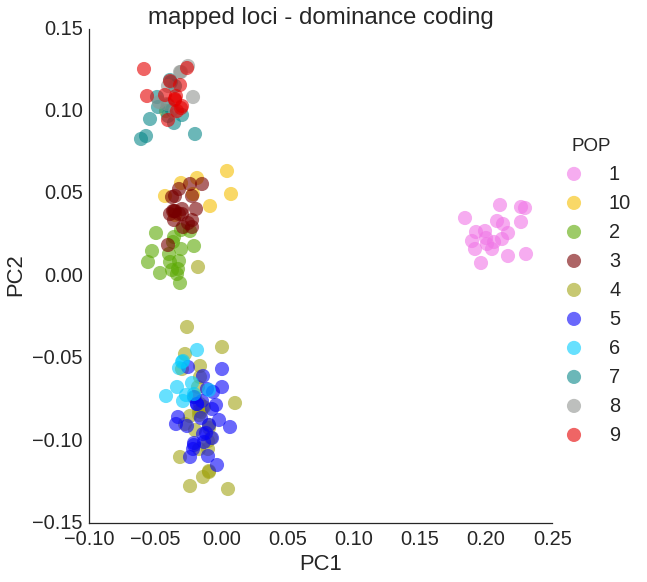

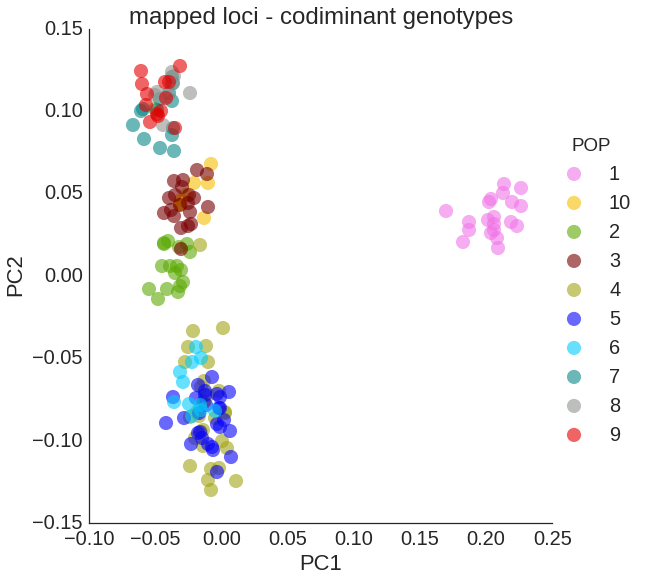

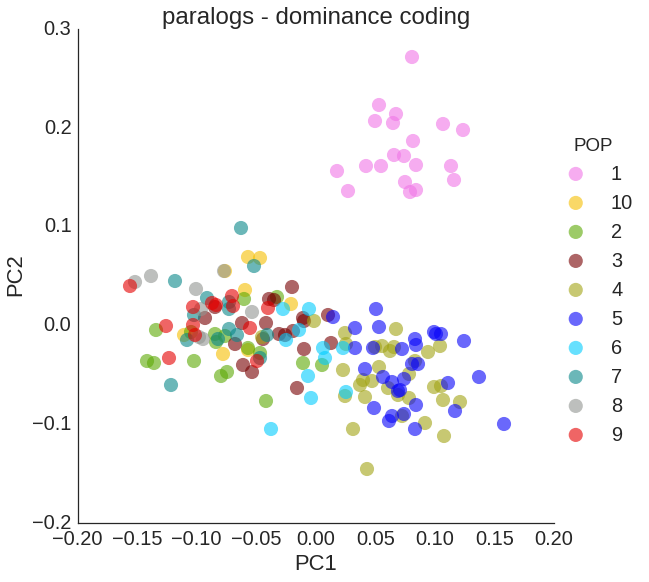

In [17]:
figsize(10, 10)
sns.lmplot('PC1', 'PC2', data= eigenvec_on_map_dom, hue = 'POP', palette=sns.xkcd_palette(pop_colors),
           fit_reg=False, size = 8, scatter_kws={"s": 200., 'alpha': .6} )
plt.title('mapped loci - dominance coding')
plt.show()

sns.lmplot('PC1', 'PC2', data= eigenvec_on_map_codom, hue = 'POP', palette=sns.xkcd_palette(pop_colors),
           fit_reg=False, size = 8, scatter_kws={"s": 200., 'alpha': .6} )
plt.title('mapped loci - codiminant genotypes')
plt.show()

sns.lmplot('PC1', 'PC2', data= eigenvec_paralogs, hue = 'POP', palette=sns.xkcd_palette(pop_colors),
           fit_reg=False, size = 8, scatter_kws={"s": 200., 'alpha': .6} )
plt.title('paralogs - dominance coding')
plt.show()

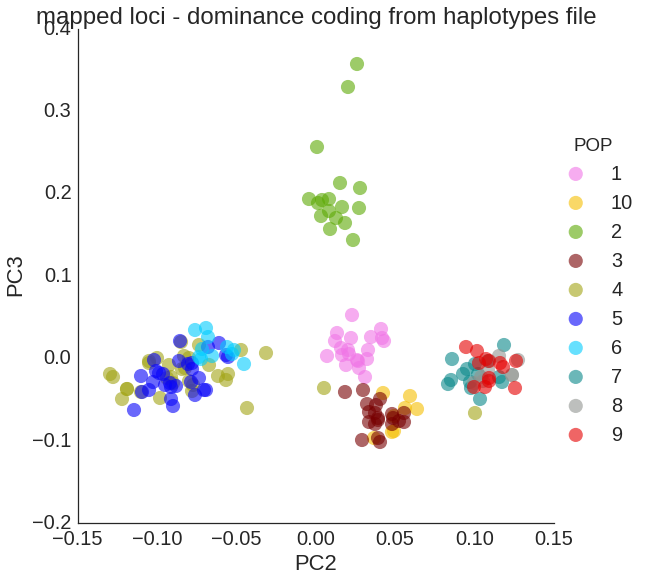

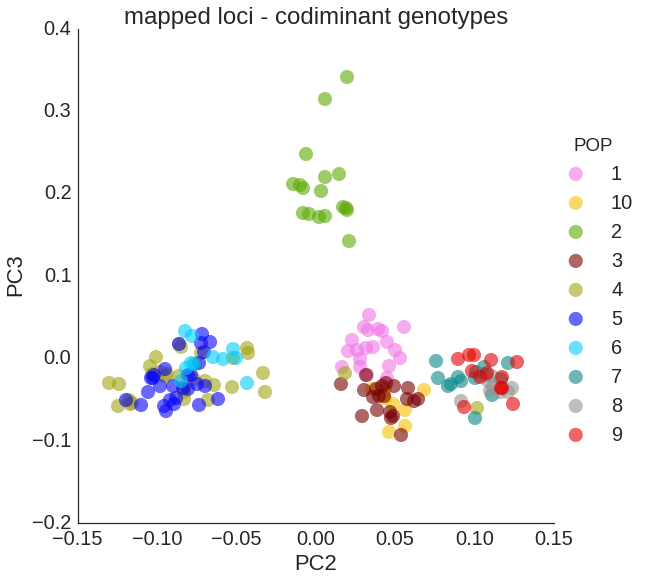

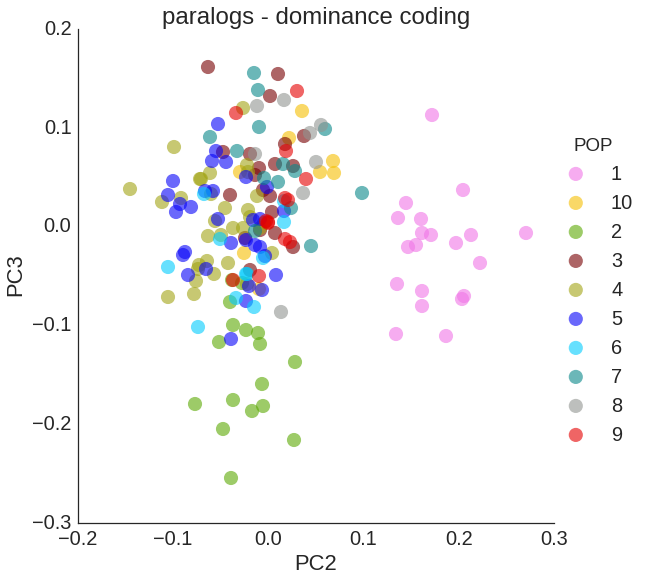

In [18]:
figsize(10, 10)
sns.lmplot('PC2', 'PC3', data= eigenvec_on_map_dom, hue = 'POP', palette=sns.xkcd_palette(pop_colors),
           fit_reg=False, size = 8, scatter_kws={"s": 200., 'alpha': .6} )
plt.title('mapped loci - dominance coding from haplotypes file')
plt.show()

sns.lmplot('PC2', 'PC3', data= eigenvec_on_map_codom, hue = 'POP', palette=sns.xkcd_palette(pop_colors),
           fit_reg=False, size = 8, scatter_kws={"s": 200., 'alpha': .6} )
plt.title('mapped loci - codiminant genotypes')
plt.show()

sns.lmplot('PC2', 'PC3', data= eigenvec_paralogs, hue = 'POP', palette=sns.xkcd_palette(pop_colors),
           fit_reg=False, size = 8, scatter_kws={"s": 200., 'alpha': .6} )
plt.title('paralogs - dominance coding')
plt.show()